In [10]:
import argparse
import copy
from itertools import product
from pathlib import Path

import pyscf
import torch
import numpy as np
import opt_einsum as oe
from torch.utils.data import DataLoader

from cadft import CC_DFT_DATA, add_args, gen_logger, MAIN_PATH
from cadft.utils import Mol
from cadft.utils import ModelDict


AU2KCALMOL = 627.5096080306


def process(data, dtype):
    """
    Load the whole data to the gpu.
    """
    if len(data.shape) == 4:
        return data.to(
            device="cuda",
            dtype=dtype,
            memory_format=torch.channels_last,
        )
    else:
        return data.to(
            device="cuda",
            dtype=dtype,
        )


class BasicDataset:
    """
    Documentation for a class.
    """

    def __init__(self, input_, weight_, batch_size, dtype):
        self.input = input_
        self.weight = weight_
        self.ids = list(input_.keys())
        self.batch_size = batch_size
        if dtype == "float32":
            self.dtype = torch.float32
        else:
            self.dtype = torch.float64

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return {
            "input": self.input[self.ids[idx]],
            "weight": self.weight[self.ids[idx]],
        }

    def load_to_gpu(self):
        """
        Load the whole data to the device.
        """
        dataloader = DataLoader(
            self,
            shuffle=False,
            batch_size=self.batch_size,
            num_workers=1,
            pin_memory=True,
        )

        dataloader_gpu = []
        for batch in dataloader:
            batch_gpu = {}
            # move images and labels to correct device and type
            (
                batch_gpu["input"],
                batch_gpu["weight"],
            ) = (
                process(batch["input"], self.dtype),
                process(batch["weight"], self.dtype),
            )
            dataloader_gpu.append(batch_gpu)
        return dataloader_gpu

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
basis = "cc-pCVDZ"
name_mol_l = ["allene"]
# name_mol_l = ["ethane"]

# 1. Init the model
modeldict = ModelDict(
    # "2024-06-25-12-52-25",
    # "2024-06-25-12-52-47",
    # "2024-06-26-00-16-07",
    # "2024-07-05-16-20-29",
    # "2024-07-06-19-28-20",
    # "2024-07-06-19-56-17",
    # "2024-07-06-19-56-21",
    # "2024-07-07-00-16-47",
    # "2024-07-07-12-56-15",
    # "2024-07-07-15-58-32",
    # "2024-07-07-17-15-22",
    # "2024-07-08-10-44-25",
    # "2024-07-08-17-30-14",
    # "2024-07-07-20-09-53",
    1,
    64,
    1,
    4,
    0,
    device,
    "float32",
    if_mkdir=False,
)
modeldict.load_model()

for key in ["1", "2"]:
    modeldict.model_dict[key].eval()

# 2. Test loop
distance_l = [0]
for (
    name_mol,
    extend_atom,
    extend_xyz,
    distance,
) in product(
    name_mol_l,
    [0],
    [1],
    distance_l,
):
    # 2.0 Prepare

    molecular = copy.deepcopy(Mol[name_mol])
    print(f"Generate {name_mol}_{distance:.4f}")
    print(f"Extend {extend_atom} {extend_xyz} {distance:.4f}")
    print(molecular)

    name = f"{name_mol}_{basis}_{extend_atom}_{extend_xyz}_{distance:.4f}"
    if abs(distance) < 1e-3:
        if (extend_atom != 0) or extend_xyz != 1:
            print(f"Skip: {name:>40}")
            continue

    if extend_atom >= len(Mol[name_mol]):
        print(f"Skip: {name:>40}")
        continue

    molecular[extend_atom][extend_xyz] += distance
    if (Path(f"{MAIN_PATH}/data/grids_mrks/") / f"data_{name}.npz").exists():
        data_real = np.load(Path(f"{MAIN_PATH}/data/grids_mrks/") / f"data_{name}.npz")
    else:
        print(f"No file: {name:>40}")
        data_real = None

    dft2cc = CC_DFT_DATA(
        molecular,
        name=name,
        basis=basis,
        if_basis_str=True,
    )
    dft2cc.test_mol()
    print(dft2cc.mol.basis)
    nocc = dft2cc.mol.nelec[0]

    # 2.1 SCF loop to get the density matrix

    dm1_scf = dft2cc.dm1_dft
    oe_fock = oe.contract_expression(
        "p,p,pa,pb->ab",
        np.shape(dft2cc.ao_0[:, 0]),
        np.shape(dft2cc.ao_0[:, 0]),
        dft2cc.ao_0,
        dft2cc.ao_0,
        constants=[2, 3],
        optimize="optimal",
    )

    def hybrid(new, old, frac_old_=0.8):
        """
        Generate the hybrid density matrix.
        """
        return new * (1 - frac_old_) + old * frac_old_

    for i in range(2500):
        input_mat = dft2cc.grids.vector_to_matrix(
            pyscf.dft.numint.eval_rho(
                dft2cc.mol,
                dft2cc.ao_0,
                dm1_scf,
            )
            + 1e-14
        )
        input_mat = torch.tensor(
            input_mat[:, np.newaxis, :, :], dtype=modeldict.dtype
        ).to("cuda")
        with torch.no_grad():
            middle_mat = modeldict.model_dict["1"](input_mat).detach().cpu().numpy()
        middle_mat = middle_mat.squeeze(1)
        # middle_mat = data_real["vxc_b3lyp"]

        vxc_scf = dft2cc.grids.matrix_to_vector(middle_mat)

        inv_r_3 = pyscf.dft.numint.eval_rho(
            dft2cc.mol, dft2cc.ao_1, dm1_scf, xctype="GGA"
        )
        exc_b3lyp = pyscf.dft.libxc.eval_xc("b3lyp", inv_r_3)[1][0]
        vxc_scf += exc_b3lyp

        vxc_mat = oe_fock(vxc_scf, dft2cc.grids.weights, backend="torch")
        vj_scf = dft2cc.mf.get_jk(dft2cc.mol, dm1_scf, 1)[0]
        _, mo_scf = np.linalg.eigh(
            dft2cc.mat_hs @ (dft2cc.h1e + vj_scf + vxc_mat) @ dft2cc.mat_hs
        )
        mo_scf = dft2cc.mat_hs @ mo_scf

        dm1_scf_old = dm1_scf.copy()
        dm1_scf = 2 * mo_scf[:, :nocc] @ mo_scf[:, :nocc].T
        error_dm1 = np.linalg.norm(dm1_scf - dm1_scf_old)
        dm1_scf = hybrid(dm1_scf, dm1_scf_old)

        if i % 10 == 0:
            print(
                f"step:{i:<8}",
                f"dm: {error_dm1::<10.5e}",
            )
        if (i > 0) and (error_dm1 < 1e-4):
            print(
                f"step:{i:<8}",
                f"dm: {error_dm1::<10.5e}",
            )
            dm1_scf = dm1_scf_old.copy()
            break

    # 2.2 check the difference of density (on grids)

    scf_rho_r = pyscf.dft.numint.eval_rho(
        dft2cc.mol,
        dft2cc.ao_0,
        dm1_scf,
    )
    cc_rho_r = pyscf.dft.numint.eval_rho(
        dft2cc.mol,
        dft2cc.ao_0,
        dft2cc.dm1_cc,
    )
    dft_rho_r = pyscf.dft.numint.eval_rho(
        dft2cc.mol,
        dft2cc.ao_0,
        dft2cc.dm1_dft,
    )
    error_scf_rho_r = np.sum(np.abs(scf_rho_r - cc_rho_r) * dft2cc.grids.weights)
    error_dft_rho_r = np.sum(np.abs(dft_rho_r - cc_rho_r) * dft2cc.grids.weights)
    print(
        f"error_scf_rho_r: {error_scf_rho_r:.2e}, error_dft_rho_r: {error_dft_rho_r:.2e}"
    )

    # 2.3 check the difference of energy (total)

    input_mat = dft2cc.grids.vector_to_matrix(
        pyscf.dft.numint.eval_rho(
            dft2cc.mol,
            dft2cc.ao_0,
            dm1_scf,
        )
        + 1e-14
    )

    arr = np.arange(len(input_mat))
    # np.random.shuffle(arr)
    print(arr, input_mat.shape)
    input_mat[:, :, :] = input_mat[arr, : ,:]

    input_mat = torch.tensor(input_mat[:, np.newaxis, :, :], dtype=modeldict.dtype).to(
        "cuda"
    )
    with torch.no_grad():
        output_mat = modeldict.model_dict["2"](input_mat).detach().cpu().numpy()
    output_mat = output_mat.squeeze(1)

    output_mat[arr, :, :] = output_mat[:, :, :]

    output_mat_exc_real = data_real["exc1_tr_b3lyp"] * dft2cc.grids.vector_to_matrix(
        scf_rho_r * dft2cc.grids.weights
    )
    output_mat_exc = output_mat * dft2cc.grids.vector_to_matrix(
        scf_rho_r * dft2cc.grids.weights
    )
    print(AU2KCALMOL * np.sum(output_mat_exc - output_mat_exc_real))

    inv_r_3 = pyscf.dft.numint.eval_rho(dft2cc.mol, dft2cc.ao_1, dm1_scf, xctype="GGA")
    exc_b3lyp = pyscf.dft.libxc.eval_xc("b3lyp", inv_r_3)[0]

    b3lyp_ene = np.sum(exc_b3lyp * scf_rho_r * dft2cc.grids.weights)
    error_ene_scf = AU2KCALMOL * (
        (
            oe.contract("ij,ji->", dft2cc.h1e, dm1_scf)
            + 0.5 * oe.contract("ij,ji->", vj_scf, dm1_scf)
            + dft2cc.mol.energy_nuc()
            + np.sum(output_mat_exc)
            + b3lyp_ene
        )
        - dft2cc.e_cc
    )
    error_ene_dft = AU2KCALMOL * (dft2cc.e_dft - dft2cc.e_cc)
    print(f"error_scf_ene: {error_ene_scf:.2e}, error_dft_ene: {error_ene_dft:.2e}")

Loading from /home/dhem/workspace/2024.1/checkpoints/checkpoint-ccdft_2024-06-26-00-16-07_64_4_0


RuntimeError: Error(s) in loading state_dict for UNet:
	Unexpected key(s) in state_dict: "inc.double_conv.1.running_mean", "inc.double_conv.1.running_var", "inc.double_conv.1.num_batches_tracked", "inc.double_conv.4.running_mean", "inc.double_conv.4.running_var", "inc.double_conv.4.num_batches_tracked", "down_layers.0.maxpool_conv.1.double_conv.1.running_mean", "down_layers.0.maxpool_conv.1.double_conv.1.running_var", "down_layers.0.maxpool_conv.1.double_conv.1.num_batches_tracked", "down_layers.0.maxpool_conv.1.double_conv.4.running_mean", "down_layers.0.maxpool_conv.1.double_conv.4.running_var", "down_layers.0.maxpool_conv.1.double_conv.4.num_batches_tracked", "down_layers.1.maxpool_conv.1.double_conv.1.running_mean", "down_layers.1.maxpool_conv.1.double_conv.1.running_var", "down_layers.1.maxpool_conv.1.double_conv.1.num_batches_tracked", "down_layers.1.maxpool_conv.1.double_conv.4.running_mean", "down_layers.1.maxpool_conv.1.double_conv.4.running_var", "down_layers.1.maxpool_conv.1.double_conv.4.num_batches_tracked", "down_layers.2.maxpool_conv.1.double_conv.1.running_mean", "down_layers.2.maxpool_conv.1.double_conv.1.running_var", "down_layers.2.maxpool_conv.1.double_conv.1.num_batches_tracked", "down_layers.2.maxpool_conv.1.double_conv.4.running_mean", "down_layers.2.maxpool_conv.1.double_conv.4.running_var", "down_layers.2.maxpool_conv.1.double_conv.4.num_batches_tracked", "down_layers.3.maxpool_conv.1.double_conv.1.running_mean", "down_layers.3.maxpool_conv.1.double_conv.1.running_var", "down_layers.3.maxpool_conv.1.double_conv.1.num_batches_tracked", "down_layers.3.maxpool_conv.1.double_conv.4.running_mean", "down_layers.3.maxpool_conv.1.double_conv.4.running_var", "down_layers.3.maxpool_conv.1.double_conv.4.num_batches_tracked", "up_layers.0.conv.double_conv.1.running_mean", "up_layers.0.conv.double_conv.1.running_var", "up_layers.0.conv.double_conv.1.num_batches_tracked", "up_layers.0.conv.double_conv.4.running_mean", "up_layers.0.conv.double_conv.4.running_var", "up_layers.0.conv.double_conv.4.num_batches_tracked", "up_layers.1.conv.double_conv.1.running_mean", "up_layers.1.conv.double_conv.1.running_var", "up_layers.1.conv.double_conv.1.num_batches_tracked", "up_layers.1.conv.double_conv.4.running_mean", "up_layers.1.conv.double_conv.4.running_var", "up_layers.1.conv.double_conv.4.num_batches_tracked", "up_layers.2.conv.double_conv.1.running_mean", "up_layers.2.conv.double_conv.1.running_var", "up_layers.2.conv.double_conv.1.num_batches_tracked", "up_layers.2.conv.double_conv.4.running_mean", "up_layers.2.conv.double_conv.4.running_var", "up_layers.2.conv.double_conv.4.num_batches_tracked", "up_layers.3.conv.double_conv.1.running_mean", "up_layers.3.conv.double_conv.1.running_var", "up_layers.3.conv.double_conv.1.num_batches_tracked", "up_layers.3.conv.double_conv.4.running_mean", "up_layers.3.conv.double_conv.4.running_var", "up_layers.3.conv.double_conv.4.num_batches_tracked". 

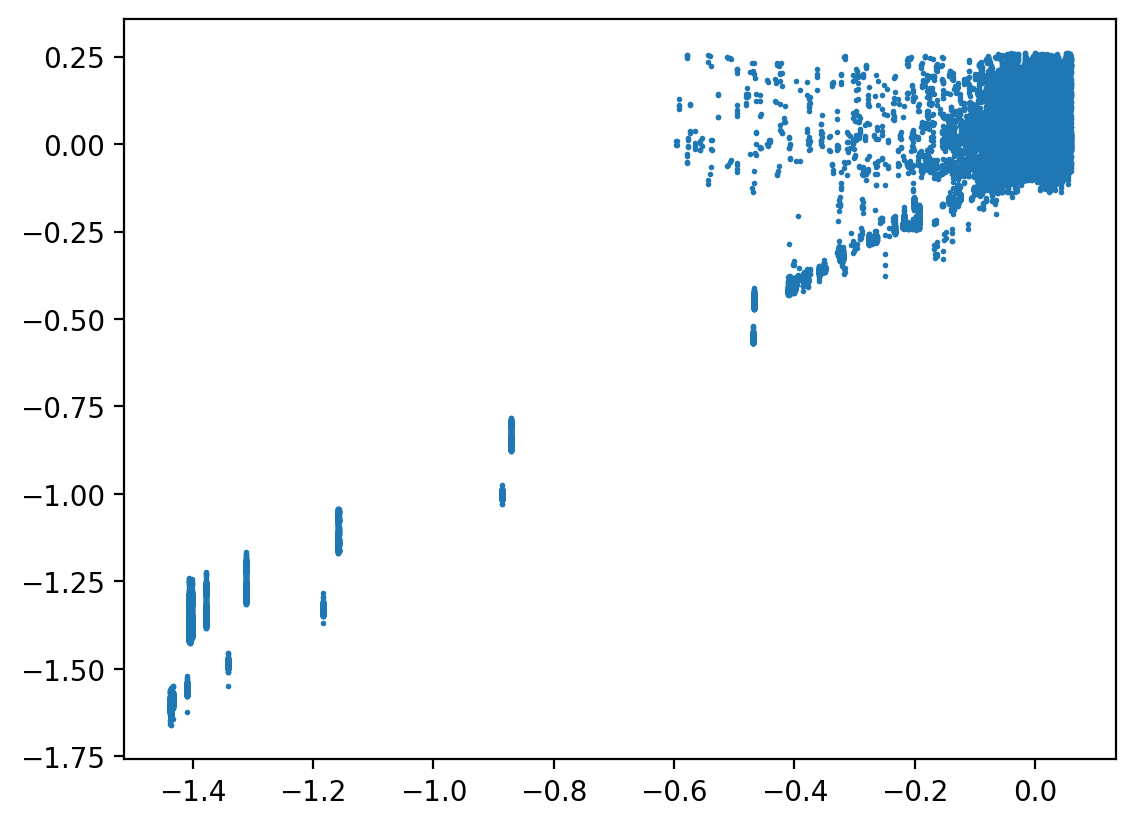

In [19]:
output_mat_exc = output_mat.flatten()
exc_real = data_real["exc1_tr_b3lyp"].flatten()

plt.scatter(exc_real, output_mat_exc, s=1)

5451


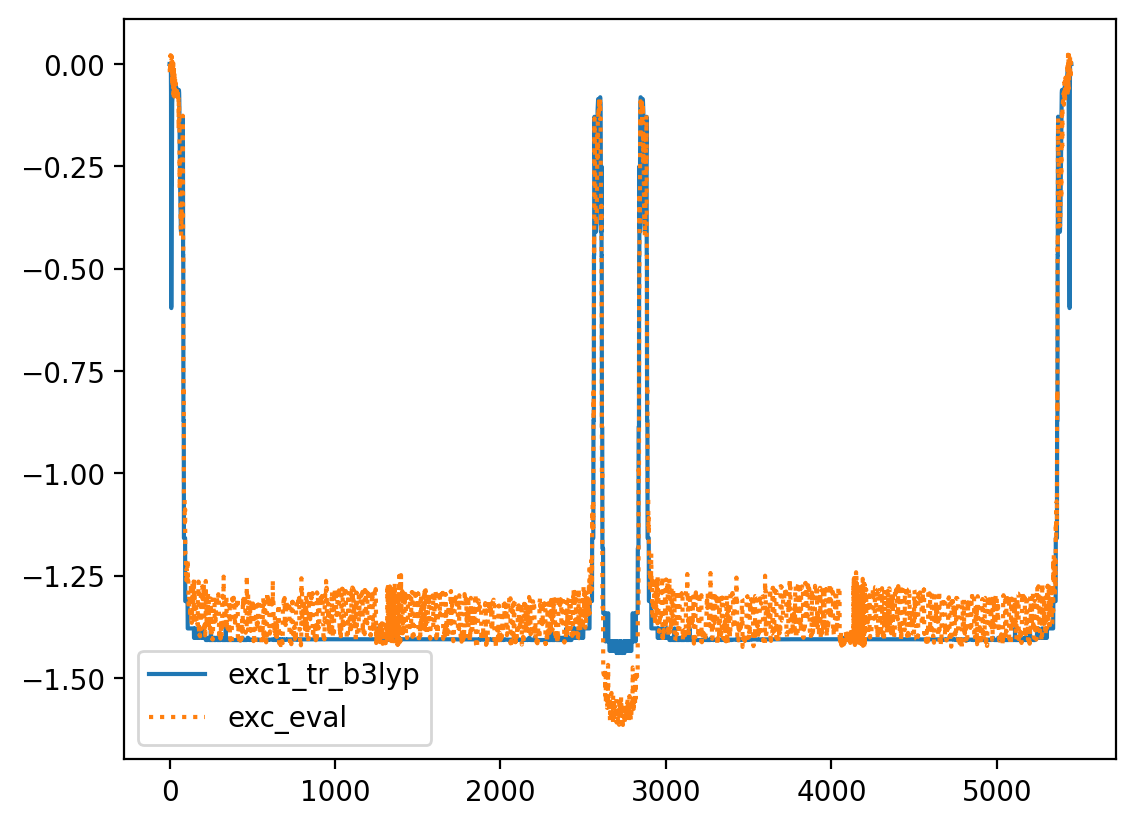

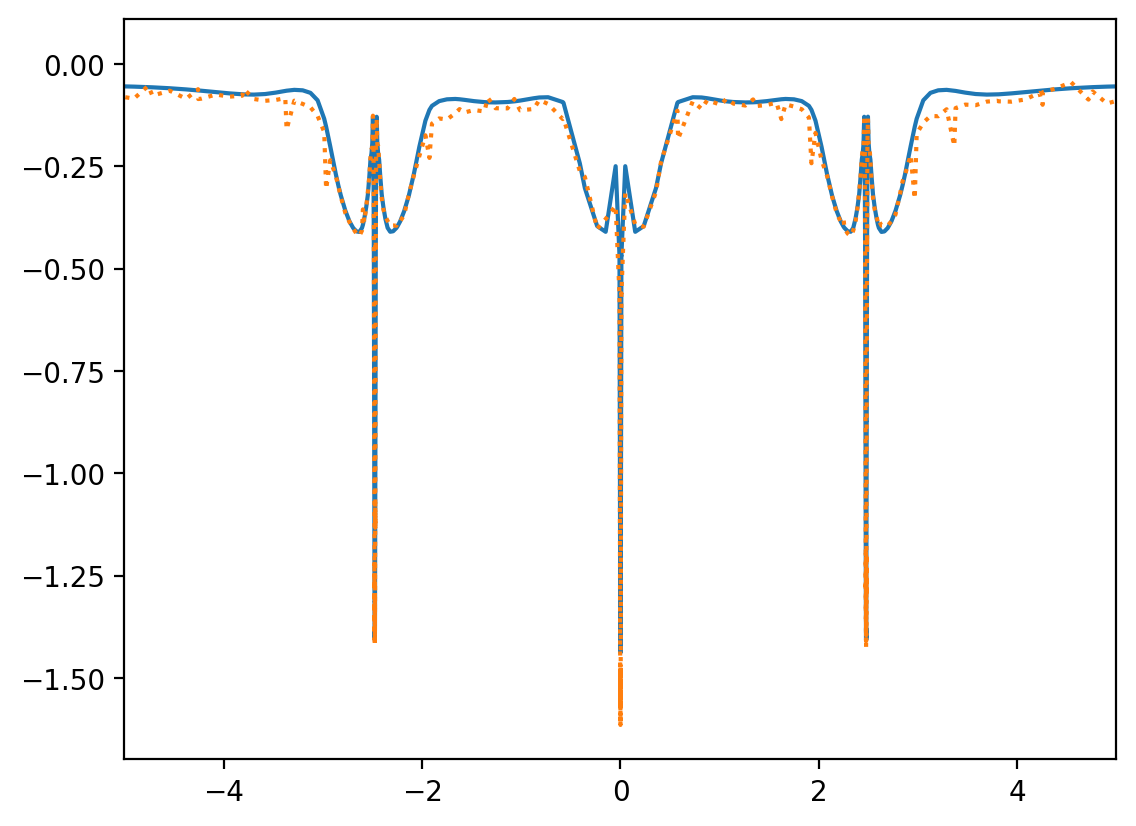

In [20]:
# output_mat_exc_real = data_real["exc_tr_b3lyp"].copy()
# output_mat_exc = output_mat.copy()

dm_weight = dft2cc.grids.vector_to_matrix(scf_rho_r)
output_mat_exc = output_mat.copy()
exc_real = data_real["exc1_tr_b3lyp"]
rho_inv = data_real["rho_inv"]

index_ = np.where(
    (np.abs(dft2cc.grids.coords[:, 1]) < 1e-3)
    & (np.abs(dft2cc.grids.coords[:, 2]) < 1e-3)
)

sort_ = np.argsort(dft2cc.grids.coords[:, 0][index_])
x = dft2cc.grids.coords[:, 0][index_][sort_]
y12 = (dft2cc.grids.matrix_to_vector(output_mat_exc))[index_][sort_]
y13 = (dft2cc.grids.matrix_to_vector(exc_real))[index_][sort_]

plt.plot(y13, label="exc1_tr_b3lyp")
plt.plot(y12, ":", label="exc_eval")
# plt.plot(x, label="x")
plt.legend(loc="best")
print(len(x))
plt.savefig(f"../manu/figures/{name_mol}-ai.pdf")
plt.show()
plt.close()

plt.plot(x, y13, label="exc1_tr_b3lyp")
plt.plot(x, y12, ":", label="exc_eval")
# plt.xlim(-0.5, 0.5)
plt.xlim(-5, 5)
plt.savefig(f"../manu/figures/{name_mol}.pdf")
plt.show()
plt.close()

In [4]:
# print((output_mat_exc - output_mat_exc_real))

In [8]:
# # molecular[0][2] = 0
# molecular

# #
# input_mat = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9]).reshape(3, 3)
# arr = np.arange(len(input_mat))
# np.random.shuffle(arr)
# print(input_mat, arr)

# input_mat[:, :] = input_mat[arr, :]
# print(input_mat)

# input_mat[arr, :] = input_mat[:, :]
# print(input_mat)

5404


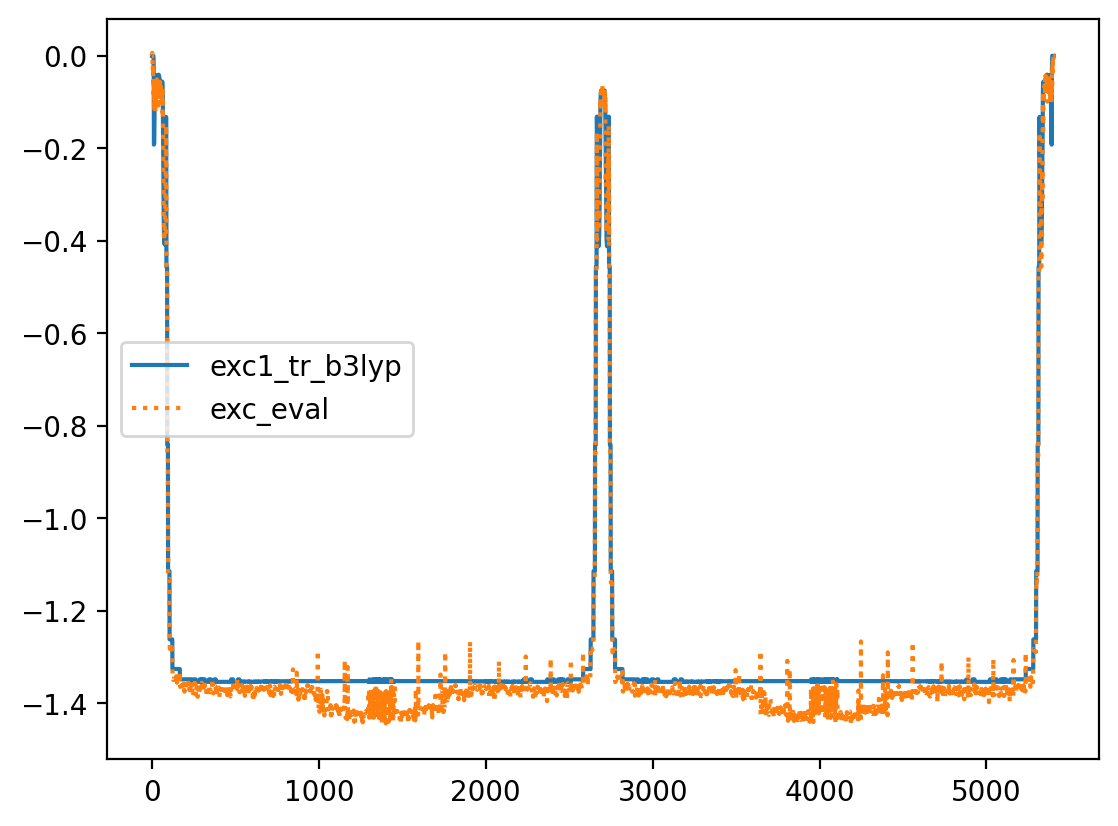

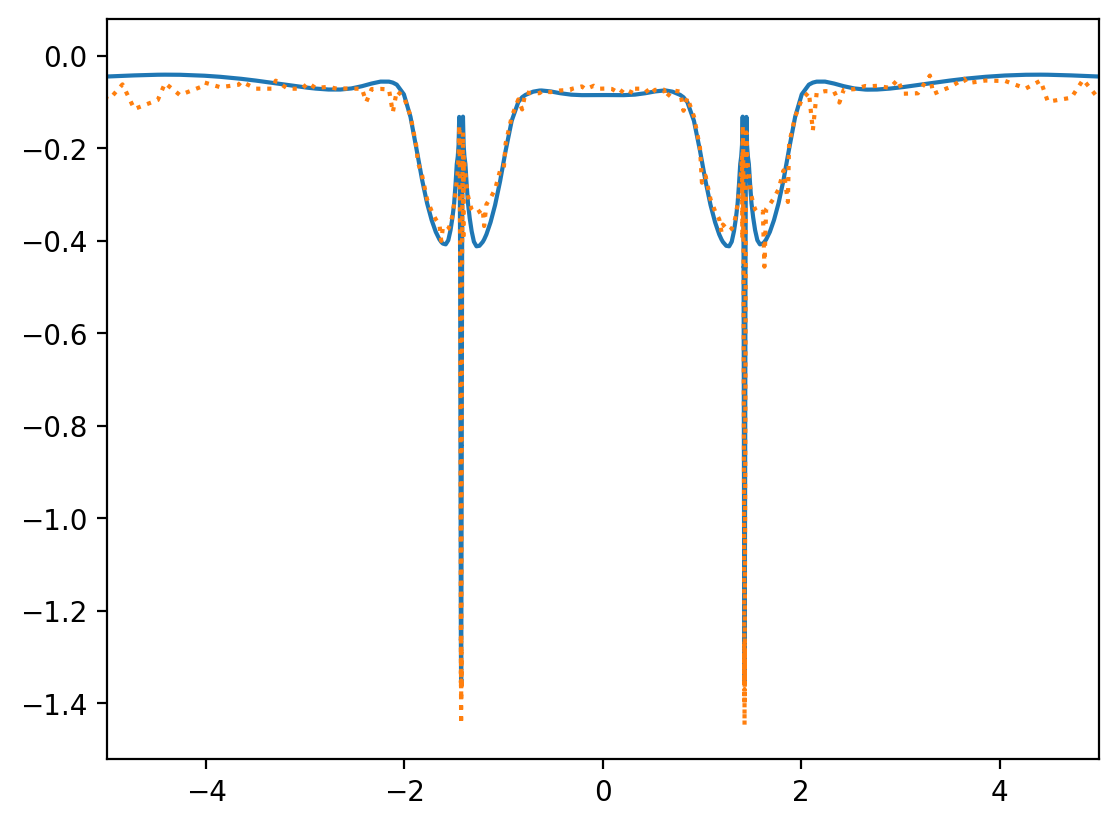

In [9]:
# output_mat_exc_real = data_real["exc1_tr_b3lyp"].copy()
# output_mat_exc = output_mat.copy()

dm_weight = dft2cc.grids.vector_to_matrix(scf_rho_r)
output_mat_exc = output_mat
exc_real = data_real["exc1_tr_b3lyp"]
rho_inv = data_real["rho_inv"]

index_ = np.where(
    (np.abs(dft2cc.grids.coords[:, 1]) < 1e-3)
    & (np.abs(dft2cc.grids.coords[:, 2]) < 1e-3)
)

sort_ = np.argsort(dft2cc.grids.coords[:, 0][index_])
x = dft2cc.grids.coords[:, 0][index_][sort_]
y12 = (dft2cc.grids.matrix_to_vector(output_mat_exc))[index_][sort_]
y13 = (dft2cc.grids.matrix_to_vector(exc_real))[index_][sort_]

plt.plot(y13, label="exc1_tr_b3lyp")
plt.plot(y12, ":", label="exc_eval")
plt.plot(x, label="x")
plt.legend(loc="best")
print(len(x))
plt.savefig(f"../manu/figures/{name_mol}-ai.pdf")
plt.show()
plt.close()

plt.plot(x, y13, label="exc1_tr_b3lyp")
plt.plot(x, y12, ":", label="exc_eval")
# plt.xlim(-0.5, 0.5)
plt.xlim(-5, 5)
plt.savefig(f"../manu/figures/{name_mol}.pdf")
plt.show()
plt.close()

12344
12344


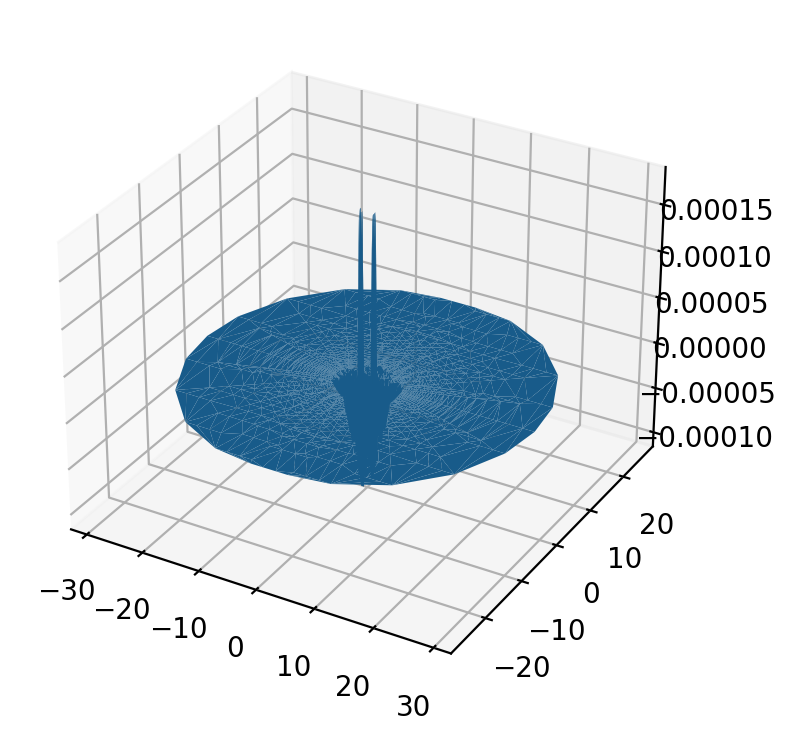

In [ ]:
index_ = np.where((np.abs(dft2cc.grids.coords[:, 2]) < 1e-4))
x = dft2cc.grids.coords[:, 0][index_]
y = dft2cc.grids.coords[:, 1][index_]
print(len(x))

z11 = (dft2cc.grids.matrix_to_vector(output_mat_exc))[index_]
z12 = (dft2cc.grids.matrix_to_vector(output_mat_exc_real))[index_]

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.plot_trisurf(x, y, z11 - z12, label="exc")
# ax.plot_trisurf(x, y, z11, label="exc")
# ax.plot_trisurf(x, y, z12, label="exc_real")
# ax.set_xlim(-5, 5)
# ax.set_ylim(-5, 5)
# ax.set_zlim(-5, 5)
# plt.xlim(1.13, 1.155)

# plt.legend(loc='upper right')
print(len(x))

In [ ]:
np.max(np.abs(z11 - z12))

0.9352685484072125